This notebook adresseses an employee scheduling problem involving multiple employees and tasks.

The objective studied is maximizing total number of tasks completed within available times of employees.

Each task can be assigned to at most one employee and **preemption** is allowed. An execution of a task can be interrupted  and continued at a later time at the same employee.  The duration of tasks is fixed (independent of the assigned employee) and it is assumed that each task can be assigned to any employee. Finally, employees are associated with availability start and end times.

The scheduling problem can be also viewed as machine scheduling problem in which employees correspond to machines.

In [1]:
import pandas as pd
import math
import numpy as np
from collections import namedtuple
import warnings
warnings.filterwarnings('ignore')

# READ DATA

In [2]:
employeesTable = pd.read_excel("C:\\Users\\167295724\\Desktop\\EmployeeScheduling\\MasterData.xlsx", sheet_name='Employees', header=0)
employeesTable = employeesTable.head(5) # select only 5 employees in order to have a small-sized problem 
employeesTable

,name,availability_start,availability_end,seniority,qualification,pay_rate
0,Anne,480,1020,11,1,25
1,Bethanie,480,1020,4,5,28
2,Betsy,480,1020,2,2,17
3,Cathy,480,1020,2,2,17
4,Cecilia,480,1020,9,5,38


In [3]:
tasksTable = pd.read_excel("C:\\Users\\167295724\\Desktop\\EmployeeScheduling\\MasterData.xlsx", sheet_name='Tasks', header=0)
tasksTable = tasksTable.head(25) # select only 25 tasks in order to have a small-sized problem
tasksTable

,task_id,task_type,task_duration,required_nbr_of_employees
0,T001,Oncology,110,1
1,T002,Cardiac Care,80,1
2,T003,Anaesthesiology,60,1
3,T004,Pediatrics,70,1
4,T005,Oncology,120,1
5,T006,Cardiac Care,80,1
6,T007,Pediatrics,80,1
7,T008,Oncology,60,1
8,T009,Anaesthesiology,110,1
9,T010,Cardiac Care,30,1


In [4]:
# subtasks with size of 1 are created in order to make tasks fully preemptive
subTasksTable = tasksTable.loc[tasksTable.index.repeat(tasksTable['task_duration'])].reset_index(drop=True)
subTasksTable['index_within_group'] = subTasksTable.groupby('task_id').cumcount() + 1
subTasksTable

,task_id,task_type,task_duration,required_nbr_of_employees,index_within_group
0,T001,Oncology,110,1,1
1,T001,Oncology,110,1,2
2,T001,Oncology,110,1,3
3,T001,Oncology,110,1,4
4,T001,Oncology,110,1,5
...,...,...,...,...,...
2125,T025,Cardiac Care,110,1,106
2126,T025,Cardiac Care,110,1,107
2127,T025,Cardiac Care,110,1,108
2128,T025,Cardiac Care,110,1,109


# PREPARE DATA

Tuple data type can be used to retrieve certain values of each row of a dataframe (to be used in the optimization model). Each tuple set can correspond to an input table and the pandas method itertuples() returns a named tuple for each row of a DataFrame.

In [5]:
employeesT  = namedtuple("employeesT",['name', 'availabilityStart', 'availabilityEnd', 'seniority', 'qualification', 'payRate'])
employees  = [employeesT(*employees_row) for employees_row in employeesTable.itertuples(index=False)]
#employees 

In [6]:
tasksT  = namedtuple("tasksT",['taskId', 'taskType', 'taskDuration','requiredNbrOfEmployees'])
tasks  = [tasksT(*tasks_row) for tasks_row in tasksTable.itertuples(index=False)]
#tasks 

In [7]:
subTasksT  = namedtuple("subTasksT",['taskId', 'taskType', 'taskDuration','requiredNbrOfEmployees','index'])
subTasks  = [subTasksT(*subTasks_row) for subTasks_row in subTasksTable.itertuples(index=False)]
#subTasks

# CREATE A MODEL INSTANCE

In [8]:
from docplex.cp.model import *
mdl = CpoModel(name='employeeScheduling') 

# DEFINE DECISION VARIABLES

In [9]:
# define processing interval of each task at each employee
tasks_itv_vars = {}   
for e in employees:
    for t in tasks:
        tasks_itv_vars[t,e] = mdl.interval_var(start=(e.availabilityStart,e.availabilityEnd), end=(e.availabilityStart,e.availabilityEnd),optional=True, size=(t.taskDuration,9999), name="interval_task{}_employee{}".format(t.taskId,e.name))
        #print(tasks_itv_vars[t,e])

In [10]:
# define break interval for each employee
break_earliest_start = 660
break_latest_end = 780
break_duration = 60
break_itv_vars = {}
for e in employees:
    break_itv_vars[e] = mdl.interval_var(start=(break_earliest_start,break_latest_end), end=(break_earliest_start,break_latest_end), optional=True, size=(break_duration), name="break_interval_employee{}".format(e.name))
    #print (break_itv_vars[e])

In [11]:
# define production processing interval of each job at each machine
sub_tasks_itv_vars = {}   # dict of interval variable for each transaction
#tasks_itv_vars = [[mdl.interval_var(optional=True, size=t.taskDuration, name="interval_task{}_employee{}".format(t.taskId,e.name)) for e in employees] for t in tasks] 
for e in employees:
    for t in tasks:
        for i in range(1,t.taskDuration+1):
            sub_tasks_itv_vars[t,e,i] = mdl.interval_var(start=(e.availabilityStart,e.availabilityEnd), end=(e.availabilityStart,e.availabilityEnd),optional=True, size=1, name="sub_interval_task{}_employee{}_subTask{}".format(t.taskId,e.name,i))
            #print(sub_tasks_itv_vars[t,e,i])

# EXPRESS OBJECTIVE FUNCTION

In [12]:
# minimize makespan
objective = mdl.sum([mdl.end_of(tasks_itv_vars[t,e]) for t in tasks for e in employees])
mdl.add(mdl.minimize(objective)) 

# DEFINE CONSTRAINTS

In [13]:
# each task should be assigned to an employee
for t in tasks:
    mdl.add(mdl.sum([mdl.presence_of(tasks_itv_vars[t,e]) for e in employees]) == 1)

In [14]:
# no overlap constraint
for e in employees:
    mdl.add(mdl.no_overlap([sub_tasks_itv_vars[t,e,i] for t in tasks for i in range(1,t.taskDuration+1) ] + [break_itv_vars[e]] ))
    mdl.add(mdl.no_overlap([tasks_itv_vars[t,e] for t in tasks]))

In [15]:
# ensure that if an employee has a task assigned, that employee should take a break
for e in employees:
    mdl.add(mdl.presence_of(break_itv_vars[e]) == mdl.any([mdl.presence_of(tasks_itv_vars[t,e]) for t in tasks]))

In [16]:
# task intervals should span over subtask intervals and it is ensured that if a task interval is present, then its all subtasks should be present
for e in employees:
    for t in tasks:
        mdl.add(mdl.span(tasks_itv_vars[t,e], [sub_tasks_itv_vars[t,e,i] for i in range(1,t.taskDuration+1)])) 
        mdl.add(mdl.presence_of(tasks_itv_vars[t,e])*t.taskDuration==mdl.sum(mdl.presence_of(sub_tasks_itv_vars[t,e,i]) for i in range(1,t.taskDuration+1))) 

In [17]:
# ensure subtasks are ordered correctly
for e in employees:
    for t in tasks:
        for i in range(2,t.taskDuration+1):
            mdl.add(mdl.end_before_start(sub_tasks_itv_vars[t,e,i-1],sub_tasks_itv_vars[t,e,i]))
            mdl.add(mdl.presence_of(sub_tasks_itv_vars[t,e,i])<=mdl.presence_of(sub_tasks_itv_vars[t,e,i-1]))             

# SOLVE THE MODEL

In [18]:
msol=mdl.solve(TimeLimit=60, execfile='C:\\Program Files\\IBM\\ILOG\\CPLEX_Studio221\\cpoptimizer\\bin\\x64_win64\\cpoptimizer.exe')
print("Solution: ")
msol.print_solution()

 ! --------------------------------------------------- CP Optimizer 22.1.0.0 --
 ! Minimization problem - 10790 variables, 21340 constraints
 ! Presolve      : 10525 extractables eliminated
 ! TimeLimit            = 60
 ! Initial process time : 2.94s (2.94s extraction + 0.01s propagation)
 !  . Log search space  : 95350.7 (before), 95350.7 (after)
 !  . Memory usage      : 119.9 MB (before), 119.9 MB (after)
 ! Using parallel search with 8 workers.
 ! ----------------------------------------------------------------------------
 !          Best Branches  Non-fixed    W       Branch decision
                        0      10790                 -
 + New bound is 0
 ! Using iterative diving.
                     4271      10789    1       899  = startOf(sub_interval_taskT019_employeeCathy_subTask120)
                     4271      10789    2       899  = startOf(sub_interval_taskT019_employeeCathy_subTask120)
                     4271      10789    3       899  = startOf(sub_interval_taskT

# PREPARE OUTPUT TABLES

In [19]:
assignmentReport = [(e.name, t.taskId, t.taskDuration
                    ,msol.get_var_solution(tasks_itv_vars[t,e]).get_start(),msol.get_var_solution(tasks_itv_vars[t,e]).get_end()) 
                       for t in tasks for e in employees if msol.get_var_solution(tasks_itv_vars[t,e]).is_present()]
assignmentReport_df = pd.DataFrame(assignmentReport, columns=['Employee', 'Task', 'Duration','StartTime','EndTime'])
assignmentReport_df = assignmentReport_df.sort_values(by=['Employee', 'StartTime'], ascending=[True, True])
assignmentReport_df 

,Employee,Task,Duration,StartTime,EndTime
10,Anne,T011,80,480,560
4,Anne,T005,120,560,680
13,Anne,T014,110,680,850
11,Anne,T012,70,850,920
22,Anne,T023,90,920,1010
17,Bethanie,T018,90,480,570
5,Bethanie,T006,80,570,650
8,Bethanie,T009,110,650,820
0,Bethanie,T001,110,820,930
1,Betsy,T002,80,480,560


In [20]:
subAssignmentReport = [(e.name, t.taskId,  t.taskDuration , i 
                    ,msol.get_var_solution(sub_tasks_itv_vars[t,e,i]).get_start(),msol.get_var_solution(sub_tasks_itv_vars[t,e,i]).get_end()) 
                       for t in tasks for e in employees for i in range(1,t.taskDuration+1) 
                       if msol.get_var_solution(sub_tasks_itv_vars[t,e,i]).is_present()]
subAssignmentReport_df = pd.DataFrame(subAssignmentReport, columns=['Employee', 'Task', 'Duration','Index','StartTime','EndTime'])
subAssignmentReport_df = subAssignmentReport_df.sort_values(by=['Employee', 'StartTime'], ascending=[True, True])
subAssignmentReport_df 

,Employee,Task,Duration,Index,StartTime,EndTime
800,Anne,T011,80,1,480,481
801,Anne,T011,80,2,481,482
802,Anne,T011,80,3,482,483
803,Anne,T011,80,4,483,484
804,Anne,T011,80,5,484,485
...,...,...,...,...,...,...
2015,Cecilia,T024,60,56,945,946
2016,Cecilia,T024,60,57,946,947
2017,Cecilia,T024,60,58,947,948
2018,Cecilia,T024,60,59,948,949


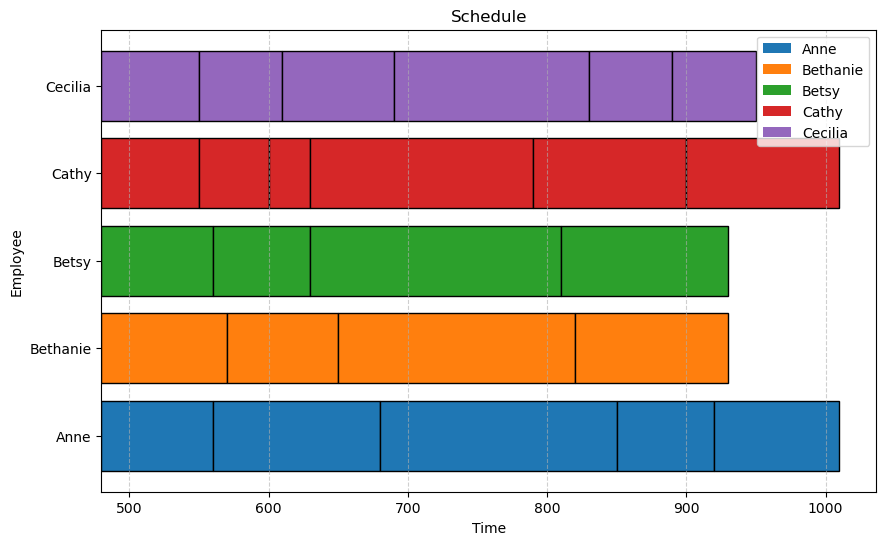

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import ListedColormap

# Your data
df = assignmentReport_df

# Automatically define colors for resources using a colormap
cmap = plt.cm.get_cmap('tab10')  # You can choose other colormaps
colors = [cmap(i) for i in range(len(df['Employee'].unique()))]
resource_colors = dict(zip(df['Employee'].unique(), colors))

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the Gantt chart
for i, row in df.iterrows():
    start_time = row['StartTime']
    end_time = row['EndTime']
    task_duration = end_time - start_time
    ax.barh(row['Employee'], task_duration, left=start_time, color=resource_colors[row['Employee']], edgecolor='black', label="EEEE")

# Customize the chart
ax.set_xlabel('Time')
ax.set_ylabel('Employee')
ax.set_title('Schedule')

# Customize legend
legend_labels = [plt.Rectangle((0,0),1,1,fc=resource_colors[resource]) for resource in df['Employee'].unique()]
ax.legend(legend_labels, df['Employee'].unique())

# Add gridlines
ax.grid(axis='x', linestyle='--', alpha=0.6)

plt.show()